# Introduction

Notebook to analyze the **False Negatives** Results for each model in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle = fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
features['tokens'] = features.apply(lambda row : tokenizer.__call__(row['feat_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Grouping Results by Model

#### Min Recall

model
bm25          28.38
lda            6.81
lsi           13.32
wordvector     6.26
Name: perc_recall, dtype: float64



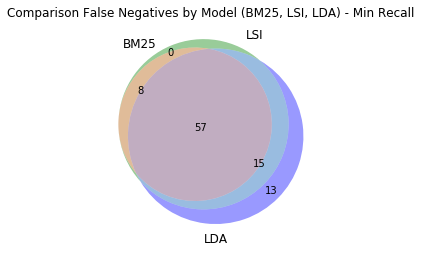

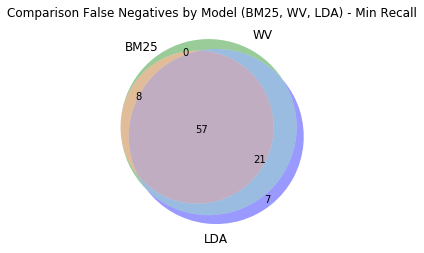

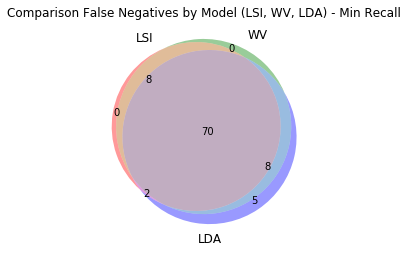

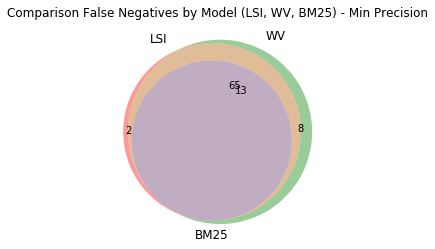

In [19]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [20]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FN:
len(bm25_exc_set): 0


LSI Exclusive FN:
len(lsi_exc_set): 0


LDA Exclusive FN:
len(lda_exc_set): 5


WV Exclusive FN:
len(wv_exc_set): 0


##### Word Clouds

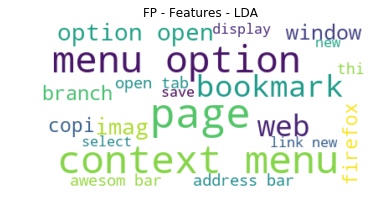

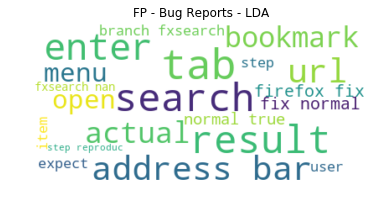

In [21]:
#aux_functions.create_wordcloud_feat_br(bm25_exc_set, bugreports=bugreports, features=features,
#                                    wc_feat_title="FP - Features - BM25",
#                                     wc_br_title="FP - Bug Reports - BM25")

#aux_functions.create_wordcloud_feat_br(lsi_exc_set, bugreports=bugreports, features=features,
#                                     wc_feat_title="FP - Features - LSI",
#                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_feat_br(lda_exc_set, bugreports=bugreports, features=features,
                                     wc_feat_title="FP - Features - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

#aux_functions.create_wordcloud_feat_br(wv_exc_set, bugreports=bugreports, features=features,
#                                     wc_feat_title="FP - Features - Word Vector",
#                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Negatives Amount by Model

In [22]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 80
LDA FN Amount: 85
BM25 FN Amount: 65
WV FN Amount: 86


#### Max Recall

model
bm25          49.32
lda           17.99
lsi           52.06
wordvector    38.11
Name: perc_recall, dtype: float64



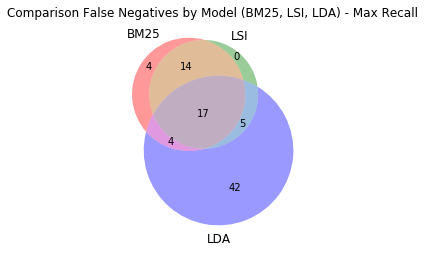

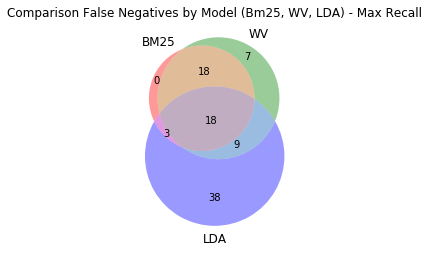

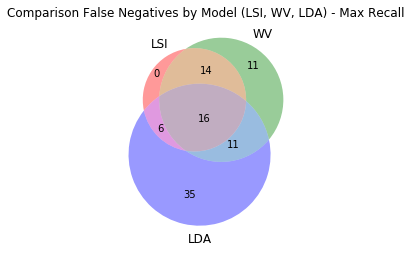

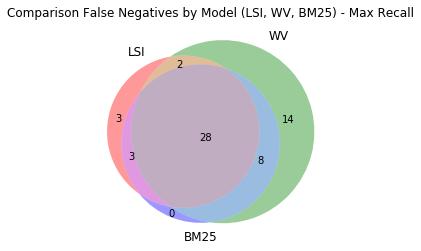

In [9]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [10]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FN:
len(bm25_exc_set): 0


LSI Exclusive FN:
len(lsi_exc_set): 0


LDA Exclusive FN:
len(lda_exc_set): 35


WV Exclusive FN:
len(wv_exc_set): 7


##### Word Clouds

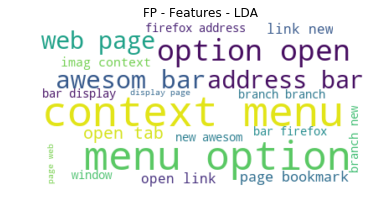

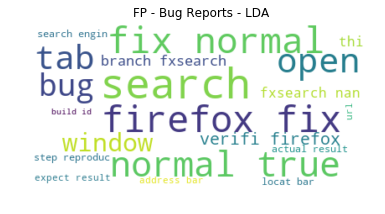

In [11]:
#aux_functions.create_wordcloud_feat_br(bm25_exc_set, bugreports=bugreports, features=features,
#                                    wc_feat_title="FP - Features - BM25",
#                                     wc_br_title="FP - Bug Reports - BM25")

#aux_functions.create_wordcloud_feat_br(lsi_exc_set, bugreports=bugreports, features=features,
#                                     wc_feat_title="FP - Features - LSI",
#                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_feat_br(lda_exc_set, bugreports=bugreports, features=features,
                                     wc_feat_title="FP - Features - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

#aux_functions.create_wordcloud_feat_br(wv_exc_set, bugreports=bugreports, features=features,
#                                     wc_feat_title="FP - Features - Word Vector",
#                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Negatives Amount by Model

In [12]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 36
LDA FN Amount: 68
BM25 FN Amount: 39
WV FN Amount: 52


#### Min Precision

model
bm25          11.87
lda            3.74
lsi           12.53
wordvector     7.14
Name: perc_precision, dtype: float64



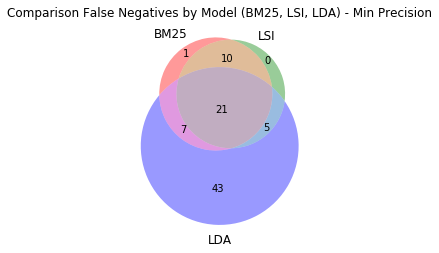

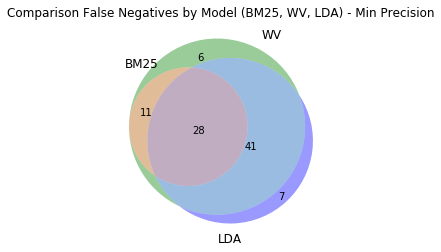

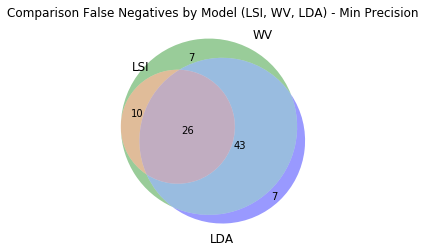

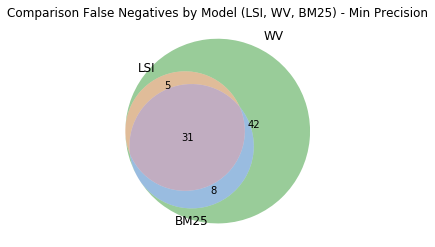

In [13]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [14]:
print("BM25 Exclusive FN:")
display(bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set)

print("\n\nLSI Exclusive FN:")
display(lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set)

print("\n\nLDA Exclusive FN:")
display(lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set)

print("\n\nWV Exclusive FN:")
display(wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


{('context_menu', 1248267),
 ('new_awesome_bar', 1294733),
 ('new_awesome_bar', 1294887),
 ('new_awesome_bar', 1334844),
 ('new_awesome_bar', 1337682),
 ('new_awesome_bar', 1353831),
 ('new_awesome_bar', 1357458)}



WV Exclusive FN:


{('browser_customization', 1318903),
 ('browser_customization', 1353831),
 ('browser_customization', 1357458),
 ('browser_customization', 1451475),
 ('indicator_device_perm', 1296322),
 ('indicator_device_perm', 1345687)}

In [15]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 36
LDA FN Amount: 76
BM25 FN Amount: 39
WV FN Amount: 86


#### Max Precision

model
bm25          30.77
lda           10.99
lsi           31.32
wordvector    19.78
Name: perc_precision, dtype: float64



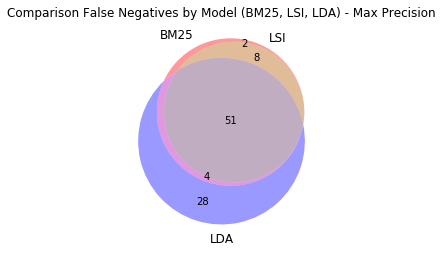

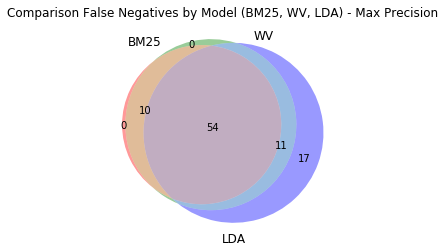

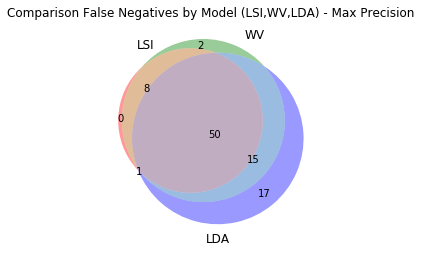

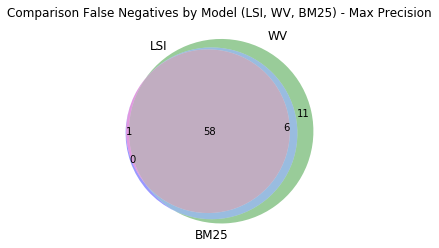

In [16]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [17]:
print("BM25 Exclusive FN:")
display(bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set)

print("\n\nLSI Exclusive FN:")
display(lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set)

print("\n\nLDA Exclusive FN:")
display(lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set)

print("\n\nWV Exclusive FN:")
display(wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


{('context_menu', 1248267),
 ('new_awesome_bar', 1276120),
 ('new_awesome_bar', 1279864),
 ('new_awesome_bar', 1291770),
 ('new_awesome_bar', 1294733),
 ('new_awesome_bar', 1294887),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1301421),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1334844),
 ('new_awesome_bar', 1335992),
 ('new_awesome_bar', 1337682),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1353831),
 ('new_awesome_bar', 1357458),
 ('new_awesome_bar', 1365887),
 ('new_awesome_bar', 1408361)}



WV Exclusive FN:


set()

In [18]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 59
LDA FN Amount: 83
BM25 FN Amount: 65
WV FN Amount: 75
